In [11]:
# Import all of the requried libraries
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pandas as pd
# import statistics
from statistics import mode,mean
from scipy import interpolate
import os

# These are all of the libraries that I manually created

import IOfunctions as IO
import GUIfunctions as GUI
import Processfunctions as process

# Through 3D slicer
# start_index = 0 # starts at 195nm
# start_index = 742 # starts at 350nm
start_index = 790 # starts at 360nm
# start_index = 1070 # starts at 420nm



### Data Loading and Formatting 
#### Load in the data
* Raw data
* Broadband output

In [12]:
# This function combines loading the data with 
def loadDataset(dataPath,start_index=790,end_index=-1,sep=','):
    Dataset = []
    print("Loading in: ", dataPath)
    for name in os.listdir(dataPath):
#         print(name)
        df = pd.read_csv(os.path.join(dataPath,name), sep=sep,engine='python', header=None)
        # trim to 360 nm
        df = df.iloc[:, start_index:]
        # convert to an array
        data_arr = df.to_numpy()
        # Sum the columns of the array
#         spectrum_arr = np.sum(data_arr[1:, 1:],axis=0)
        spectrum_arr = np.mean(data_arr[1:, 1:],axis=0)
        # Grab the wavelength values
        wavelength_arr = data_arr[0, 1:]
        # Concatenate the vectors as columns
        data_arr = np.concatenate((wavelength_arr.reshape(-1,1), spectrum_arr.reshape(-1,1)), axis=1)
        # append to the dataset
        Dataset.append(data_arr)
    Dataset = np.array(Dataset,dtype='float')
    return Dataset

# LOADING DATASET 

trialPath = "C:/Users/David/OneDrive - Queen's University/1 Graduate Studies/1 Thesis Research/KidneyData_march3/March3_KidneyCollectionWithDrRen/Mar03"
sampleNameList = [f for f in os.listdir(trialPath) if f.startswith('Patient')]

# define a pandas df to store the incoming data
Dataset_df = pd.DataFrame(columns=['PatientID', 'SampleID', 'Label (numeric)', 'Label', 'Data'])
class0_name = 'Normal'
class1_name = 'Cancer'


# sampleNameDict = {}
for sampleName in sampleNameList:
    patientID = sampleName.split('_')[0]
    sampleID = sampleName.split('_')[1] + '_' +sampleName.split('_')[2]
    # define the class names for folders which start with cancer or normal
    classNameList = [f for f in os.listdir(os.path.join(trialPath,sampleName)) if f.startswith('Cancer') or f.startswith('Normal')]
    # Remove names containing AmbientLight
    classNameList = [f for f in classNameList if not f.endswith('AmbientLight')]
    # for each folder sampleName folder, check if the class folders exist
    for className in classNameList:
        # if className contains cancer, then label = 1
        if class0_name in className:
            label = 0
        else:
            label = 1
        # Check to see if the path exists
        dataPath = os.path.join(trialPath,sampleName,className)
        if os.path.exists(dataPath):
            # sampleNameDict[sampleName+'_'+className] = 1 #loadDataset(dataPath,start_index=start_index, sep=',')
            data = loadDataset(dataPath,start_index=start_index, sep=',')
            # for each data file, append to the dataset
            for i in range(data.shape[0]):
                new_row = {'PatientID':patientID, 
                        'SampleID':sampleID, 
                        'Label (numeric)':label, 
                        'Label':className, 
                        'Data':data[i,:,:]
                }
                # Dataset_df = Dataset_df.append(new_row, ignore_index=True)
                Dataset_df = pd.concat([Dataset_df, pd.DataFrame([new_row])], ignore_index=True)

Loading in:  C:/Users/David/OneDrive - Queen's University/1 Graduate Studies/1 Thesis Research/KidneyData_march3/March3_KidneyCollectionWithDrRen/Mar03\PatientA_Sample1_back\Cancer
Loading in:  C:/Users/David/OneDrive - Queen's University/1 Graduate Studies/1 Thesis Research/KidneyData_march3/March3_KidneyCollectionWithDrRen/Mar03\PatientA_Sample1_back\Normal
Loading in:  C:/Users/David/OneDrive - Queen's University/1 Graduate Studies/1 Thesis Research/KidneyData_march3/March3_KidneyCollectionWithDrRen/Mar03\PatientA_Sample1_front\Cancer
Loading in:  C:/Users/David/OneDrive - Queen's University/1 Graduate Studies/1 Thesis Research/KidneyData_march3/March3_KidneyCollectionWithDrRen/Mar03\PatientA_Sample1_front\Normal
Loading in:  C:/Users/David/OneDrive - Queen's University/1 Graduate Studies/1 Thesis Research/KidneyData_march3/March3_KidneyCollectionWithDrRen/Mar03\PatientA_Sample2_back\Cancer
Loading in:  C:/Users/David/OneDrive - Queen's University/1 Graduate Studies/1 Thesis Researc

In [13]:
Dataset_df

,PatientID,SampleID,Label (numeric),Label,Data
0,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.0055262738350994245], ..."
1,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.0021762760675127974], ..."
2,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.004287867652463011], [..."
3,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.003312623581628423], [..."
4,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.008101678916785034], [..."
...,...,...,...,...,...
394,PatientA,Sample3_front,0,Normal,"[[360.14014912872346, 0.0016519205206512518], ..."
395,PatientA,Sample3_front,0,Normal,"[[360.14014912872346, 0.0020590573105211396], ..."
396,PatientA,Sample3_front,0,Normal,"[[360.14014912872346, 0.002182790787293707], [..."
397,PatientA,Sample3_front,0,Normal,"[[360.14014912872346, 0.0011315139349880599], ..."


In [20]:
# Now that I have everything compiled into a dataframe, I can now split the data based on the class labels

# Get the unique class labels
classLabels = Dataset_df['Label'].unique()

# Split the data into two classes
allNormal_df = Dataset_df[Dataset_df['Label (numeric)'] == 0]
allCancer_df = Dataset_df[Dataset_df['Label (numeric)'] == 1]

# Extract the data from the dataframe
data_0 = np.array(allNormal_df['Data'].tolist())
labels0 = np.array(allNormal_df['Label (numeric)'].tolist())
data_1 = np.array(allCancer_df['Data'].tolist())
labels1 = np.array(allCancer_df['Label (numeric)'].tolist())


In [22]:
data_0.shape



(84, 2858, 2)

#### Load in the broadband transfer function

In [23]:
def loadSpectrum(path, col_name=None,start_index=774,end_index=-1,sep=';'):
#     df = pd.read_csv(path + name,sep=';',engine='python')
    df = pd.read_csv(path,sep=sep,engine='python')
#     print(df)
    if not(col_name == None):
        df[col_name] = df.index
    data = df[start_index:end_index]
#     print(data)
    data_arr = data.to_numpy()
    data_arr = np.array(data_arr,dtype='float')
    return data_arr

# LOAD IN BASELINES

dataPath = os.getcwd()
folderName = 'March2022_raw_data'
file_name = 'SLS201L_Spectrum_reformatted.csv'
dataPath_BrOut = os.path.join(dataPath,"data",folderName,file_name)
print(dataPath_BrOut)
baseline_BrOut_raw = loadSpectrum(dataPath_BrOut, 'Wavelength', start_index=10, end_index=675, sep=',')
# Interpolate such that the downloaded spectrum has the same values of the data
x = baseline_BrOut_raw[:,0]
y = baseline_BrOut_raw[:,1]
f = interpolate.interp1d(x,y)
xnew = data_0[0,:,0]
ynew = f(xnew)
baseline_BrOut = np.transpose(np.array([xnew,ynew]))
print(baseline_BrOut.shape)
print('Data shape', data_0.shape)

c:\Spectroscopy_TrackedTissueSensing\data\March2022_raw_data\SLS201L_Spectrum_reformatted.csv
(2858, 2)
Data shape (84, 2858, 2)


360.14014912872346


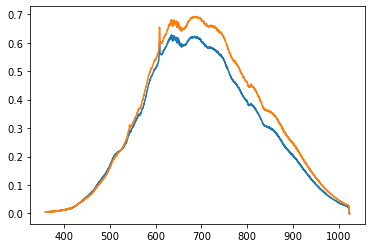

In [24]:
plt.plot(data_0[0,:,0],data_0[0,:,1])
plt.plot(data_1[0,:,0],data_1[0,:,1])
data_0.shape
print(data_0[0,0,0])

### Display the raw data

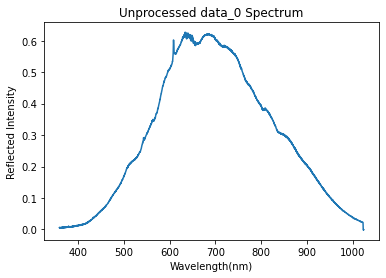

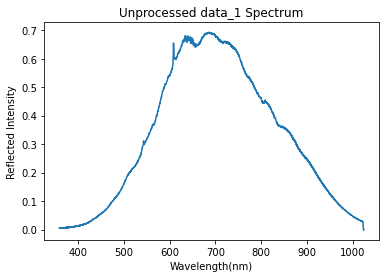

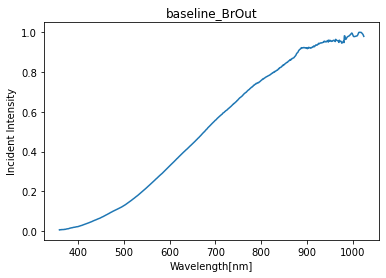

In [25]:
# Displaying all of the spectra to visually inspect results

# This should be in GUI with all the inputs as parameters
wavelength_start = data_0[0,0,0]
wavelength_end = data_0[0,-1,0]

w = np.linspace(wavelength_start,wavelength_end,len(data_0[1]))
# Display an example of data_0
GUI.plotSpectra(xdata=data_0[0,:,0],ydata=data_0[0,:,1],xlab='Wavelength(nm)',ylab='Reflected Intensity',
                title='Unprocessed data_0 Spectrum')
# Display an example of data_1
GUI.plotSpectra(xdata=data_1[0,:,0], ydata=data_1[0,:,1],xlab='Wavelength(nm)',ylab='Reflected Intensity',
                title='Unprocessed data_1 Spectrum' )
# Display an example of broadband output
GUI.plotSpectra(xdata=baseline_BrOut[:,0],ydata=baseline_BrOut[:,1],xlab="Wavelength[nm]",
            ylab='Incident Intensity',title='baseline_BrOut')

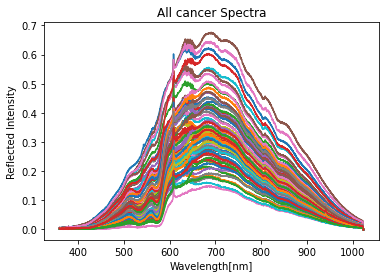

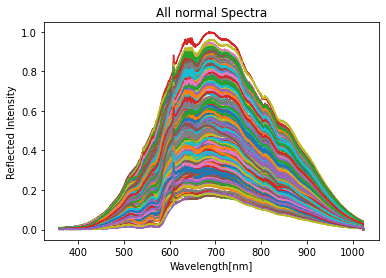

In [26]:
# Plot all samples of class0 on a single figure without using plotSpectra
plt.figure()
for i in range(len(data_0)):
    plt.plot(data_0[i,:,0],data_0[i,:,1])
plt.title('All cancer Spectra')
plt.xlabel('Wavelength[nm]')
plt.ylabel('Reflected Intensity')
plt.show()

# Plot all samples of class1 on a single figure without using plotSpectra
plt.figure()
for i in range(len(data_1)):
    plt.plot(data_1[i,:,0],data_1[i,:,1])
plt.title('All normal Spectra')
plt.xlabel('Wavelength[nm]')
plt.ylabel('Reflected Intensity')
plt.show()

In [27]:
# data_0_save = data_0.copy()
# data_1_save = data_1.copy()

# data_0 = data_0_save.copy()
# data_1 = data_1_save.copy()


Text(0.5, 1.0, 'All cancer Spectra')

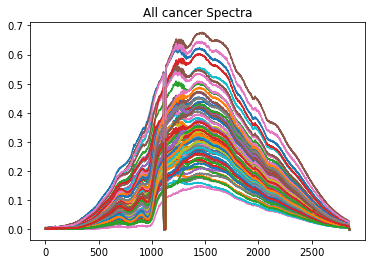

In [28]:
# temporayily remove the peak caused by ambient light
data_0_new = data_0.copy()
data_1_new = data_1.copy()
# Set the spectra to zero between 600 and 650 nm
# This is to remove the background noise using no functions

start_index = 1110
width = 20
end_index = start_index + width
for i in range(len(data_0_new)):
    data_0_new[i,start_index:end_index,1] = 0
for i in range(len(data_1_new)):
    data_1_new[i,start_index:end_index,1] = 0
    
# Plot them again
# Plot all samples of class0 on a single figure without using plotSpectra
plt.figure()
for i in range(len(data_0_new)):
    plt.plot(data_0_new[i,:,1])
plt.title('All cancer Spectra')

### Preprocessing of the data
* Normalize so peak is 1
* Crop to 360nm to 1024nm
* Divide by the broadband output

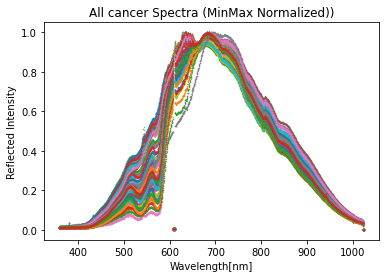

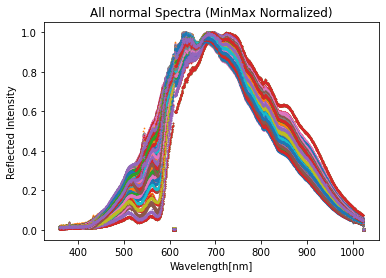

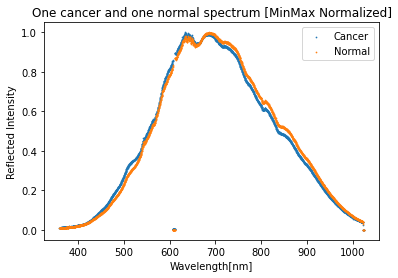

In [29]:
# Normalize the data
data_0_norm = data_0_new.copy()
data_1_norm = data_1_new.copy()
data_0_norm = process.normalize(data_0_norm)
data_1_norm = process.normalize(data_1_norm)

# Plot them again
# Plot all samples of class0 on a single figure without using plotSpectra
plt.figure()
for i in range(len(data_0_norm)):
    plt.scatter(data_0_norm[i,:,0] ,data_0_norm[i,:,1],s=0.1)
plt.title('All cancer Spectra (MinMax Normalized))')
plt.xlabel('Wavelength[nm]')
plt.ylabel('Reflected Intensity')

# Plot all samples of class1 on a single figure without using plotSpectra
plt.figure()
for i in range(len(data_1_norm)):
    plt.scatter(data_1_norm[i,:,0],data_1_norm[i,:,1],s=0.5)
plt.title('All normal Spectra (MinMax Normalized)')
plt.xlabel('Wavelength[nm]')
plt.ylabel('Reflected Intensity')


# plot one cancer and one normal spectrum on a scatter plot
plt.figure()
plt.scatter(data_0_norm[0,:,0],data_0_norm[0,:,1],s=0.5)
plt.scatter(data_1_norm[0,:,0],data_1_norm[0,:,1],s=0.5)
plt.title('One cancer and one normal spectrum [MinMax Normalized]')
plt.xlabel('Wavelength[nm]')
plt.ylabel('Reflected Intensity')
plt.legend(['Cancer','Normal'])




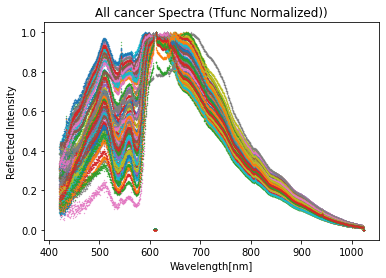

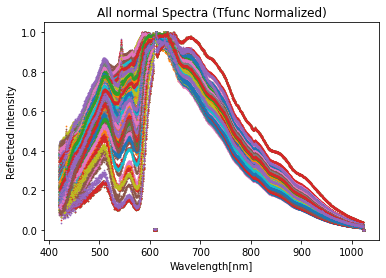

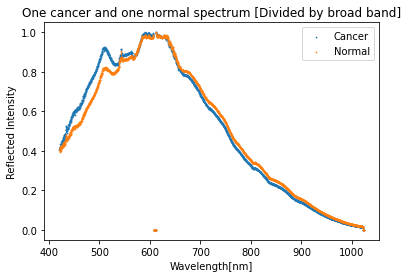

In [30]:
FLAG_Baseline = True
# Load in the baseline 
baseline = baseline_BrOut # --------------------------------- flag
baseline = process.normalize(baseline)[:,1]

data_0_norm = data_0_new[:,280:,:].copy()
data_1_norm = data_1_new[:,280:,:].copy()
baseline = baseline[280:].copy()
tFunc = baseline

def divTfuc(inputData,tFunc, flag):    
    outputData = inputData.copy()
    if FLAG_Baseline:
        # For each spectra
        for i in range (inputData[:,:,1].shape[0]):
            data = inputData[i,:,1]
            # Divide by the baseline transfer function
            outputData[i,:,1] = data / tFunc 
    outputData = process.normalize(outputData)
    return outputData
# call the function
data_0_norm_T = divTfuc(data_0_norm,tFunc, FLAG_Baseline)
data_1_norm_T = divTfuc(data_1_norm,tFunc, FLAG_Baseline)
# Display the arguemtns and output
freq = data_0_norm[0,:,0]

# Plot all samples of class0 on a single figure without using plotSpectra
plt.figure()
for i in range(len(data_0_norm_T)):
    plt.scatter(data_0_norm_T[i,:,0] ,data_0_norm_T[i,:,1],s=0.1)
plt.title('All cancer Spectra (Tfunc Normalized))')
plt.xlabel('Wavelength[nm]')
plt.ylabel('Reflected Intensity')

# Plot all samples of class1 on a single figure without using plotSpectra
plt.figure()
for i in range(len(data_1_norm_T)):
    plt.scatter(data_1_norm_T[i,:,0],data_1_norm_T[i,:,1],s=0.5)
plt.title('All normal Spectra (Tfunc Normalized)')
plt.xlabel('Wavelength[nm]')
plt.ylabel('Reflected Intensity')

# plot one cancer and one normal spectrum on a scatter plot
plt.figure()
plt.scatter(data_0_norm_T[0,:,0],data_0_norm_T[0,:,1],s=0.5)
plt.scatter(data_1_norm_T[0,:,0],data_1_norm_T[0,:,1],s=0.5)
plt.title('One cancer and one normal spectrum [Divided by broad band]')
plt.xlabel('Wavelength[nm]')
plt.ylabel('Reflected Intensity')
# add a lengend
plt.legend(['Cancer','Normal'])




In [31]:
# # Normalize all data
# # cropStart = 280 # 420nm
# cropStart = 0 # 360nm
# data_0_norm = divTfuc(data_0[:,cropStart:,:], baseline,FLAG_Baseline)
# data_0_saved = data_0_norm.copy()
# print('shape:', data_0_norm.shape)
# # data_0_norm = process.subtractBaseline(data_0_norm,baseline)
# data_0_norm = process.normalize(data_0_norm)

# data_1_norm = divTfuc(data_1[:,cropStart:,:], baseline,FLAG_Baseline)
# data_1_saved = data_1_norm.copy()

# print('Size of data_0,', data_0_norm.shape)
# print('Size of data_1,', data_1_norm.shape)
# print(tFunc.min())


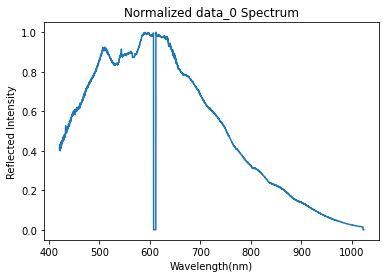

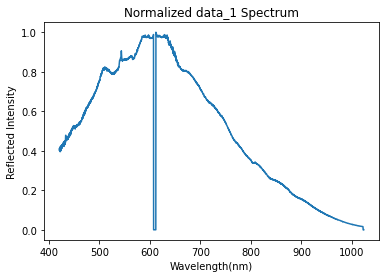

In [32]:
data_0_norm = data_0_norm_T
data_1_norm = data_1_norm_T

# Plots of the normalized spectra
GUI.plotSpectra(xdata=data_0_norm[0,:,0],ydata=data_0_norm[0,:,1],xlab='Wavelength(nm)',ylab='Reflected Intensity',
                title='Normalized data_0 Spectrum' )
GUI.plotSpectra(xdata=data_1_norm[0,:,0],ydata=data_1_norm[0,:,1],xlab='Wavelength(nm)',ylab='Reflected Intensity',
                title='Normalized data_1 Spectrum' )

### Perform PCA to downsample to 2 axes and then plot with classes colour coded to look for clustering?



(399, 2578, 2)


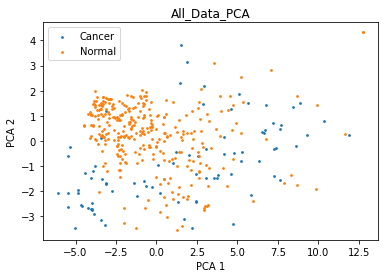

In [35]:
# Perform PCA on the data to scale it down to 2 dimensions
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# concatenate the data
data = np.concatenate((data_0_norm,data_1_norm),axis=0)
print(data.shape)
pca.fit(data[:,:,1])
data_0_pca = pca.transform(data_0_norm[:,:,1])
data_1_pca = pca.transform(data_1_norm[:,:,1])

# Plot the PCA data
plot_title = 'All_Data_PCA'
plt.figure()
plt.scatter(data_0_pca[:,0],data_0_pca[:,1],s=3)
plt.scatter(data_1_pca[:,0],data_1_pca[:,1],s=3)
plt.title(plot_title)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(['Cancer','Normal'])
# save the plot as a vector graphic
plt.savefig('Experiments/PrelimKidney/'+ plot_title + '.svg')



